# Traffic Flow Regression - V4
## - <i>Model Selection: Hyperparameter Tuning</i>
 - this notebook builds upon traffic_flow_regression_V3 by selecting the optimal model with the optimal hyperparameters
 - see EDA.ipynb for a deeper understanding of the data

# Imports

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, validation_curve
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
from mlxtend.evaluate import bias_variance_decomp
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR


# Read Dataset for site N03121A
We will focus on site N03121A again

In [51]:
overall_df = pd.read_csv('ml_datasets/v2_dataset.csv')
df = overall_df[overall_df['site']=='N03121A']
df.head()

,time_(half_hour),start_time,site,day,date,X,Y,flow,month,time_(hour),...,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
700,00:00,2024-10-12 00:00:00,N03121A,FR,2022-01-04,-6.424314,53.357202,109,1,0,...,0,0.0,0,3.6,0,2.2,-0.3,6.0,75,1003.5
701,00:00,2024-10-12 00:00:00,N03121A,FR,2022-01-14,-6.424314,53.357202,97,1,0,...,0,0.0,0,4.1,0,3.5,2.6,7.4,90,1039.5
702,00:00,2024-10-12 00:00:00,N03121A,FR,2022-01-21,-6.424314,53.357202,90,1,0,...,0,0.0,0,4.9,0,3.9,2.5,7.3,84,1042.1
703,00:00,2024-10-12 00:00:00,N03121A,FR,2022-01-28,-6.424314,53.357202,96,1,0,...,0,0.0,0,2.9,0,2.6,2.0,7.1,93,1035.3
704,00:00,2024-10-12 00:00:00,N03121A,FR,2022-02-18,-6.424314,53.357202,149,2,0,...,0,1.0,0,4.0,0,3.5,2.7,7.4,91,995.2


In [52]:
cat_features = ['day', 'time_(hour)']
num_features = ['previous_flow_N01111A','previous_flow_N01151A','previous_flow_N02111A','previous_flow_N02131A','previous_flow_N03121A','overall_previous_flow',
                'distance_N01111A',
       'duration_N01111A',
       'distance_N01151A', 'duration_N01151A', 'distance_N02111A',
       'duration_N02111A', 'distance_N02131A', 'duration_N02131A',
       'distance_N03121A', 'duration_N03121A',
       'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum',
       'msl']


# Model Selection
- From v2 notebook we saw Linear Regression, KNN and the multi-layer perceptron gave the best performance for predicting the traffic flow
- We will now focus on landing on the best final model to use via hyperparameter tuning

## 1. An interpretable model
- Interpretability of a machine learning model can often be hugely important and valuable for key stakeholders
- Deep learning and neural networks create models that can provide excellent performance, however the complexity of these models make them difficult to interpret, meaning we cannot understand why the network is predicting the way it is based on the input features
**Why is interpretability important?**
- One of the use cases of our traffic flow model could be to help make decisions on traffic management systems
- Having accurate predictions of traffic flow is definetly useful, but what is also useful is understanding why traffic is predicted to be higher at a certain time 
- This could perhaps help the council identify some root causes of high traffic flow and thus fix any problems at the root of the issue rather than responding to traffic flow in real time with our complex but accurate neural network model
- Don't get me wrong, having an accurate prediction model is still hugely useful, especially in a scenario like this where you are realistically always going to have periods of high traffic flow. However with the massive advances in machine learning it can become easy to dismiss simpler models if they are not providing sufficient predictive power. However issues like this highlight they are still hugely usefula and actually display real benefits over powerful neural networks at times

### 1.1 Linear Regression
In notebook V1 we tried out using a linear regression model. We saw that the results weren't great but let's investigate this more rigorously and explain clearly why it doesn't work
- we won't concern ourselves with the data preprocessing here as it is standard enough (one hot encoding and numerical feature scaling)

In [ ]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                ('scaler', StandardScaler())  # Standardize numerical features
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())  # Set the depth
])

Lets now evaluate the performance of linear regression using 5-fold cross validation on the train and test cets

In [ ]:
def cross_validate_train_and_test(pipeline, cv, X, y):

    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    train_maes = []
    test_maes = []

    train_r2s = []
    test_r2s = []

    for train_index, val_index in kf.split(X):
        X_cv_train, X_cv_val = X.iloc[train_index], X.iloc[val_index]  # Use iloc for DataFrame
        y_cv_train, y_cv_val = y.iloc[train_index], y.iloc[val_index]  # Consistent naming

        # Fit the model
        pipeline.fit(X_cv_train, y_cv_train)

        # Calculate train and test errors
        predictions_train = pipeline.predict(X_cv_train)
        predictions_val = pipeline.predict(X_cv_val)
        
        mae_train = mean_absolute_error(y_cv_train, predictions_train)
        mae_val = mean_absolute_error(y_cv_val, predictions_val)

        r2_train = r2_score(y_cv_train, predictions_train)
        r2_test = r2_score(y_cv_val, predictions_val)


        train_maes.append(mae_train)
        test_maes.append(mae_val)

        train_r2s.append(r2_train)
        test_r2s.append(r2_test)

    mean_mae_test = np.mean(test_maes)
    mean_mae_train = np.mean(train_maes)
    mean_r2_test = np.mean(test_r2s)
    mean_r2_train = np.mean(train_r2s)

    print('Mean MAE Test:', mean_mae_test)
    print('Mean MAE Train:', mean_mae_train)
    print('Mean R2 Test:', mean_r2_test)
    print('Mean R2 Train:', mean_r2_train)

    return mean_mae_test, mean_mae_train, mean_r2_test, mean_r2_train

In [ ]:
cross_validate_train_and_test(pipeline_lr, 5, X, y)

Mean MAE Test: 334.5108878867841
Mean MAE Train: 333.89353880237945
Mean R2 Test: 0.20120012603045603
Mean R2 Train: 0.20437901516932602


(np.float64(334.5108878867841),
 np.float64(333.89353880237945),
 np.float64(0.20120012603045603),
 np.float64(0.20437901516932602))

#### Observations
- Cool! Compared to our analysis in notebook v1 we see a much better model being fit (MAE was 521 in that case). However the error is still too high for my liking
- The key thing to notice here is the very close values between the train and test errors. This indicates the model is **underfitting** and has **high bias**
    - lets verify this via a bias-variance decomposition of the squared error

#### Bias-Variance Decompisition

In [57]:
def bias_variance_pipeline(pipeline, X, y):

        pipeline.fit(X_train, y_train)
        # Separate the preprocessing step from the pipeline
        preprocessor = pipeline.named_steps['preprocessor']

        # Transform the training and test data using the preprocessing step
        X_train_processed = preprocessor.transform(X_train)
        X_test_processed = preprocessor.transform(X_test)

        # Now pass the processed NumPy arrays to bias_variance_decomp
        avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
                pipeline.named_steps['regressor'],  # Use only the regressor step here
                X_train_processed, y_train.ravel(),  # Processed data (NumPy arrays)
                X_test_processed, y_test.ravel(),    # Processed data (NumPy arrays)
                loss='mse',
                random_seed=123)

        print(f"Average Expected Loss: {avg_expected_loss}")
        print(f"Average Bias: {avg_bias}")
        print(f"Average Variance: {avg_var}")


In [58]:
bias_variance_pipeline(pipeline_lr, X_train, y_train)

/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_12223/1476791940.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train_processed, y_train.ravel(),  # Processed data (NumPy arrays)
/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_12223/1476791940.py:15: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_test_processed, y_test.ravel(),    # Processed data (NumPy arrays)


Average Expected Loss: 156414.90157659826
Average Bias: 156300.07895993176
Average Variance: 114.82261666649342


#### Observations
- as predicted, the majority of the expected loss is coming from the bias term as opposed to the variance 
- we should therefore look at a more complex model
    - One we we could increase the complexity of the model is via polynomial features so let's try this

##### 2.2.1.1 Polynomial Regression

In [59]:
def create_poly_pipeline(degree):
    preprocessor = ColumnTransformer(
            transformers=[
                ('num', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                    ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree=degree))  # Standardize numerical features
                ]), num_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
            ]
            )

    # Create the pipeline
    pipeline_lr_poly = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())  # Set the depth
    ])
    return pipeline_lr_poly

Let's experiment with a few values of "degree" that controls the exponent of the polynomial

In [60]:
mae_test = []
mae_train = []
degrees = [2]#, 3, 4, 5]
for degree in degrees:
    print('Degree Polynomial: ', degree)
    mean_mae_test, mean_mae_train, _, _ = cross_validate_train_and_test(create_poly_pipeline(degree), 5, X, y)
    mae_test.append(mean_mae_test)
    mae_train.append(mean_mae_train)
    print('')


Degree Polynomial:  2
Mean MAE Test: 142.47585401571993
Mean MAE Train: 139.09452992125082
Mean R2 Test: 0.8218158175657502
Mean R2 Train: 0.8312239415826109



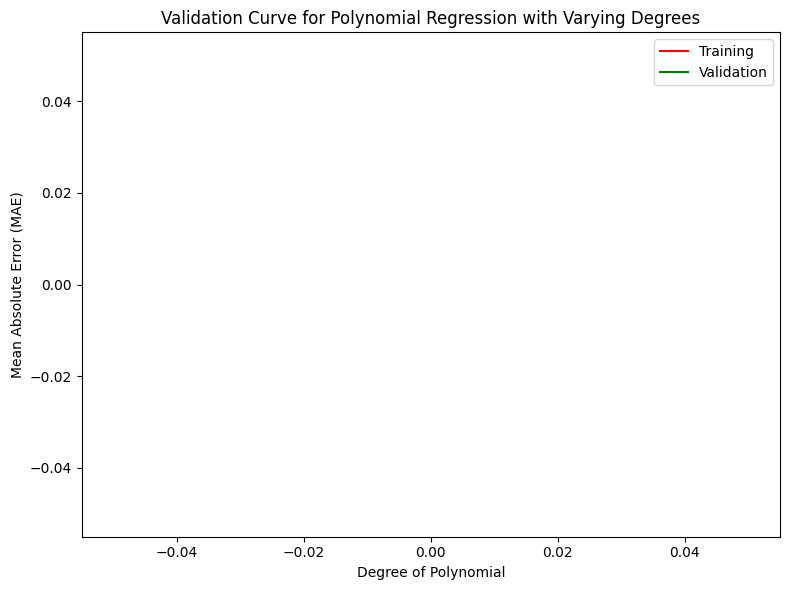

In [61]:
plt.figure(figsize=(8, 6))
plt.plot(degrees[0:-1], mae_test[0:-1], label="Training", color="r")
plt.plot(degrees[0:-1], mae_train[0:-1], label="Validation", color="g")
plt.title("Validation Curve for Polynomial Regression with Varying Degrees")
plt.xlabel("Degree of Polynomial")
plt.ylabel("Mean Absolute Error (MAE)")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

#### Observations
- we see a polynomial fit with degree = 3 gives the best generalisation performance here, before the model starts to severely overfit
- we could investigate variants of linear regression with regularisation such as Ridge and Lasso regression on these higher degree polynomials to see if we can stop overfitting while retaining the higher perofrmance they are showing on the test set. However the benefits are not hugely better and regularisation will come at the cost of decreases training error. Also computational complexity becomes a concern at these higher degree polynomials

### 2.2.1 Support Vector Machine

In [62]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                ('scaler', StandardScaler())  # Standardize numerical features
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel="linear")) 
])

In [63]:
cross_validate_train_and_test(pipeline_svm, 5, X, y)

Mean MAE Test: 265.6272240847917
Mean MAE Train: 264.74610828140965
Mean R2 Test: 0.17875467014077875
Mean R2 Train: 0.1814525870035984


(np.float64(265.6272240847917),
 np.float64(264.74610828140965),
 np.float64(0.17875467014077875),
 np.float64(0.1814525870035984))

Observations
- Output is quite poor compared to linear regression so this model doesn't seem suited either

## 2.3 Tree Models
We will next look at tree models a little more in depth than we have before

### 2.3.1 Decision Tree
(No preprocessing steps needs for decision tree)

In [64]:
preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor())  # Set the depth
])

In [65]:
cross_validate_train_and_test(pipeline_dt, 5, X, y)

Mean MAE Test: 246.77794677804226
Mean MAE Train: 239.70081146752017
Mean R2 Test: 0.5016359714657641
Mean R2 Train: 0.5312883614370925


(np.float64(246.77794677804226),
 np.float64(239.70081146752017),
 np.float64(0.5016359714657641),
 np.float64(0.5312883614370925))

#### Observations
- The performance is worse than linear regression this time now we have reduced the amount of features.
- The model is underfitting indicating high bias. Let's confirm this via a bias_variance decomposition

In [66]:
bias_variance_pipeline(pipeline_dt, X, y)

/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_12223/1476791940.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train_processed, y_train.ravel(),  # Processed data (NumPy arrays)
/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_12223/1476791940.py:15: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_test_processed, y_test.ravel(),    # Processed data (NumPy arrays)


Average Expected Loss: 100877.65006886423
Average Bias: 97786.51720175426
Average Variance: 3091.132867109952


We see again the bias is much higher than the variance.
- Let's try more complex tree models

### 2.3.2 Random Forest & GBT

In [67]:
preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())  
])

pipeline_gbt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])

In [68]:
print('Random Forest \n')
cross_validate_train_and_test(pipeline_rf, 5, X, y)
print('Gradient Boosted Tree')
cross_validate_train_and_test(pipeline_gbt, 5, X, y)


Random Forest 

Mean MAE Test: 246.82734020374215
Mean MAE Train: 239.70891274171763
Mean R2 Test: 0.5013584219077203
Mean R2 Train: 0.5311665450873319
Gradient Boosted Tree
Mean MAE Test: 258.8054224632032
Mean MAE Train: 255.85703118706783
Mean R2 Test: 0.48515188515971347
Mean R2 Train: 0.4983098415278189


(np.float64(258.8054224632032),
 np.float64(255.85703118706783),
 np.float64(0.48515188515971347),
 np.float64(0.4983098415278189))

Results are still poor so lets not go with a tree model

## 2.4 Other Models

### 2.4.1 KNN

In [69]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                ('scaler', StandardScaler())  # Standardize numerical features
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=4, n_jobs=-1)) 
])

In [70]:
cross_validate_train_and_test(pipeline_knn, 5, X, y)


Mean MAE Test: 102.00994831055297
Mean MAE Train: 75.87646680384216
Mean R2 Test: 0.8636728939136911
Mean R2 Train: 0.923301083835692


(np.float64(102.00994831055297),
 np.float64(75.87646680384216),
 np.float64(0.8636728939136911),
 np.float64(0.923301083835692))

Observations
- KNN gives performance comparable with Polynomial regression

In [71]:

preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                ('scaler', StandardScaler())  # Standardize numerical features
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_nn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(max_iter=1000, solver='lbfgs', alpha=0.001)) 
])

In [72]:
cross_validate_train_and_test(pipeline_nn, 5, X, y)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network

Mean MAE Test: 72.91865298584159
Mean MAE Train: 40.39399363757735
Mean R2 Test: 0.9374347426809084
Mean R2 Train: 0.9839348504374288


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


(np.float64(72.91865298584159),
 np.float64(40.39399363757735),
 np.float64(0.9374347426809084),
 np.float64(0.9839348504374288))

In [73]:
include
- seb ratcha 
- applied ml in pyton2, validation curve

SyntaxError: invalid syntax (3995488660.py, line 2)